# PyTorch Regression Tutorial

이번 실습에서는 PyTorch를 이용한 간단한 선형회구 실습을 진행합니다. 십습때는 캘리포니아 주택에 관한 데이터셋을 이용하였고, 개인 과제에서는 다양한 데이터셋을 이용하여 실습해봅니다.

학습 목표:
- 기본 PyTorch의 작업플로우를 시연해본다.
- 회귀에 대한 간단한 신경망을 만들어본다.
- 결과를 시각화 해본다.

---

This tutorial demonstrates a simple linear regression using PyTorch. We'll predict house prices using the California Housing dataset.

Learning Objectives:

- Understand basic PyTorch workflow
- Build a simple neural network for regression
- Train and evaluate the model
Visualize results

## 1. Import Libraries

데이터 처리, 모델 구축 및 시각화를 위한 필수 라이브러리를 임포트합니다.

---
Import necessary libraries for data processing, model building, and visualization.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_california_housing
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Load and Explore Data

케글에서 찾은 주머니쥐 데이터셋을 로드하고 그 구조를 탐구해봅니다.

Load possum dataset and explore its structure.

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Kaggle에서 다운받은 csv 파일 경로
# 사용할 데이터: Possum Regression (주머니쥐 성별)
csv_path = "/content/sample_data/possum.csv"

# 2. 타깃 컬럼 이름 설정
TARGET_COL = "taill"  # 'tail'을 'taill'로 수정

df = pd.read_csv(csv_path)
print("원본 데이터 크기:", df.shape)
print(df.head())

# 데이터셋 정보 출력
print("=== Raw Dataset Info ===")
print(f"Shape (rows, cols): {df.shape}\n")

print("Columns:")
print(df.columns.tolist(), "\n")

print("Dtypes:")
print(df.dtypes, "\n")

print("=== Basic numeric statistics ===")
print(df.describe().T)   # 각 컬럼별 count, mean, std, min, max 등

원본 데이터 크기: (104, 14)
   case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0     1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1     2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2     3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3     4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4     5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   

   earconch   eye  chest  belly  
0      54.5  15.2   28.0   36.0  
1      51.2  16.0   28.5   33.0  
2      51.9  15.5   30.0   34.0  
3      52.2  15.2   28.0   34.0  
4      53.2  15.1   28.5   33.0  
=== Raw Dataset Info ===
Shape (rows, cols): (104, 14)

Columns:
['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'] 

Dtypes:
case          int64
site          int64
Pop          object
sex          object
age         float64
hdlngth     float64


## 3. Data Preprcessing

트레이닝 데이터와 테스트 데이터를 분리하고, 더 나은 학습 성능을 위해 피처들을 정규화합니다.


Split the data into training and test sets, and normalize features for better training performance.

In [29]:
# 2) y, X 분리
y = df[TARGET_COL].values.astype(np.float32)
X = df.drop(columns=[TARGET_COL])

# 3) 범주형(문자열) → 원핫 인코딩 (성능에 중요!)
X = pd.get_dummies(X)

# 4) 결측치 처리 (수치형 평균)
X = X.fillna(X.mean(numeric_only=True))

# 5) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

# 6) 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== Preprocessing Completed ===")
print("Train shape:", X_train_scaled.shape)
print("Test shape :", X_test_scaled.shape)
print("Number of features after encoding:", X_train_scaled.shape[1])

=== Preprocessing Completed ===
Train shape: (83, 15)
Test shape : (21, 15)
Number of features after encoding: 15


In [16]:
# 셋 사이즈 지정
# # Split data into train and test sets (80-20 split)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# print(f"Training set size: {X_train.shape[0]} samples")
# print(f"Test set size: {X_test.shape[0]} samples")

# # 리그레션 문제에서 스탠다드크레일러 자주 사용
# # 갖고있는 피처의 범위를 0~1로 상대적인 값으로 변경해서 사용 -> 더 빠른 학습 가능
# # 이런거 하나하나가 학습에 영향을 줌
# # Normalize features using StandardScaler
# # This helps neural networks train faster and more stably
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 83 samples
Test set size: 21 samples

✓ Data normalized (mean=0, std=1)


## 4. Convert to PyTorch Tensors

넘파이 배열을 PyTorch 텐서로 변환하고 배치 처리를 위한 데이터로더를 만듭니다.

Convert NumPy arrays to PyTorch tensors and create DataLoaders for batch processing.

In [30]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
# 배치사이즈가 ram 영향을 끼침(본인의 ram 스펙에 맞게 지정)
# 32, 16, 8 등등
# 더미만큼 모델이 학습 시작
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 2
Number of test batches: 1


## 5. Model Definition  

회귀 문제를 위한 간단한 피드포워드 신경망을 정의합니다.

아키텍처:
- 입력 레이어: 12개의 입력 특징(feature)
- 은닉층 1: 64개의 뉴런, ReLU 활성화 함수 사용
- 은닉층 2: 32개의 뉴런, ReLU 활성화 함수 사용
- 출력 레이어: 1개의 뉴런 (예측된 꼬리 길이)

Define a simple feedforward neural network for regression.

Architecture:
- Input layer: 8 features
- Hidden layer 1: 64 neurons with ReLU activation
- Hidden layer 2: 32 neurons with ReLU activation
- Output layer: 1 neuron (predicted taill length)


In [31]:
# 선형 컴볼루션, 렐루 이용힌 간단한 회귀모델

class RegressionModel(nn.Module):

    # 어떤 블록을 사용할지??
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    # 레이어를 어떤 순서로 쌓을 지 정의
    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# 모델의 가중치를 초기화 해주는 것 -> 학습이 되지 않은 상태로
# 이렇게 하지 않으면 오버피팅 발생할 수도 있음
# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


## 6. Loss Function and Optimizer

학습을 위한 손실함수와 옵티마이저를 정의합니다.

- 손실 함수: 평균제곱오차(MSE) — 회귀 문제에서 표준적으로 사용됨
- 옵티마이저: Adam — 적응적 학습률을 사용하는 옵티마이저

Define the loss function and optimizer for training.

  - Loss Function: Mean Squared Error (MSE) - standard for regression
  - Optimizer: Adam - adaptive learning rate optimizer

In [32]:
# 최적화?
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# 모든 딥러닝에서 옵션으로 사용
# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


## 7. Training Loop

모델을 학습하고 에폭 별 손실을 추적합니다.

학습 과정(Training Process):
- Forward pass: 모델이 예측값을 계산함
- Compute loss: 예측값과 실제 값을 비교하여 손실을 계산함
- Backward pass: 손실을 기준으로 기울기(gradient)를 계산함
- Update weights: 옵티마이저를 통해 모델의 가중치를 업데이트함

Train the model and track the loss over epochs.

Training Process:

- Forward pass: compute predictions
- Compute loss: compare predictions with true values
- Backward pass: compute gradients
- Update weights: optimize parameters

In [33]:
# 학습 시작
# Training parameters
num_epochs = 100

# 로스값을 저장해두면 오버피팅 등을 확인할 때 유용
# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 로스값을 뒷 단계에 전달 -> 가중치 업그레이드에 영향
        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 셋 나눈거 중 70퍼센트꺼 안에서 진행한다는 점!
    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 1343.0997 | Test Loss: 1319.5608
Epoch [20/100] | Train Loss: 1274.1431 | Test Loss: 1242.1591
Epoch [30/100] | Train Loss: 1110.1444 | Test Loss: 1082.2454
Epoch [40/100] | Train Loss: 848.3624 | Test Loss: 811.5614
Epoch [50/100] | Train Loss: 464.7117 | Test Loss: 461.2475
Epoch [60/100] | Train Loss: 197.2122 | Test Loss: 178.1080
Epoch [70/100] | Train Loss: 83.4620 | Test Loss: 65.0346
Epoch [80/100] | Train Loss: 56.1676 | Test Loss: 41.0832
Epoch [90/100] | Train Loss: 41.7317 | Test Loss: 34.5168
Epoch [100/100] | Train Loss: 34.4407 | Test Loss: 29.6229
------------------------------------------------------------
Training complete!


## 8. Visualize Training Progress

모델이 에폭(epoch)에 따라 어떻게 학습되었는지 확인하기 위해
학습 손실과 테스트 손실을 그래프로 표현합니다.

Plot the training and test losses to see how the model learned over time.

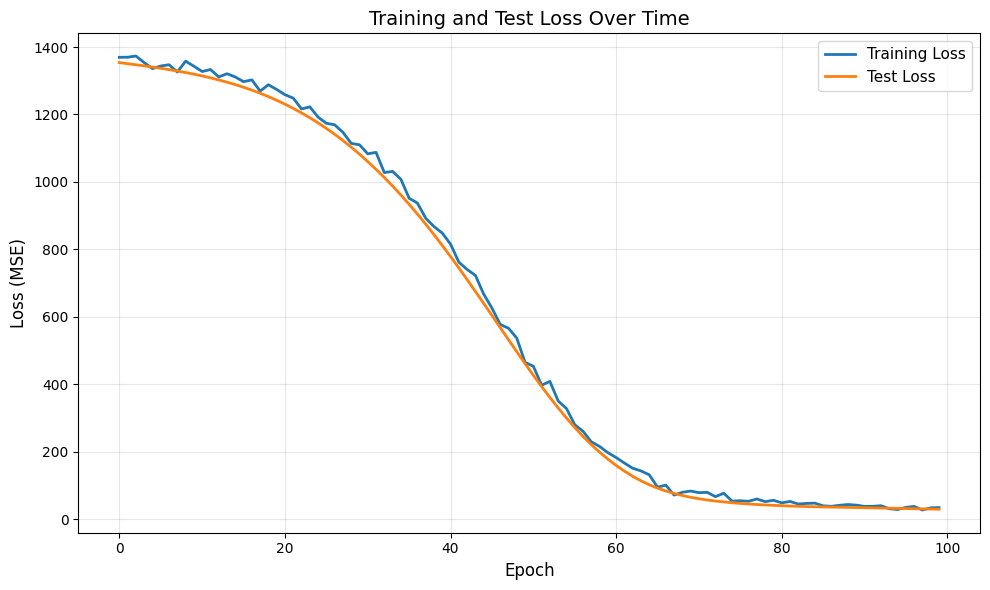

Final Training Loss: 34.4407
Final Test Loss: 29.6229


In [34]:
# 발리데이션한 로스값 - Test Loss
# 에폭을 진행할 수록 로스가 점점 떨어지는 것 확인할 수 있음
# 파란색은 안정적인데 주황색이 불안정하게 떨어진 경우
# 이 모델은 training set에 과적합된 것임!
# 이때 epoke을 조정하는 등 옵션을 하나씩 조정할 수 있음!

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## 9. Model Evaluation

테스트 셋에서의 모델을 평가하고 예측값과 실제값의 차이를 시각화합니다.

Evaluate the model on the test set and visualize predictions vs actual values.

In [43]:
# 예측한 값이랑 얼마나 차이가 나는지 확인하는것
# 아까 나눠놓은 30퍼로 진행하는 것

# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

# 차이가 얼마나 나는가 - Mean A E
# 0.3470
# 정규분포를 0~1로 바꿔놓을 거라서 이런 수치도 그렇게 생각해야함
# R score: 모델의 개선 가능성을 평가할 수 있는 지표임
print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by {mae:.2f} units.")
print(f"Model explains {r2*100:.2f}% of the variance in {TARGET_COL} values.")

Model Performance on Test Set:
Mean Squared Error (MSE):  29.6229
Root Mean Squared Error (RMSE): 5.4427
Mean Absolute Error (MAE): 4.6516
R² Score: -6.7806

Interpretation:
On average, predictions are off by 4.65 units.
Model explains -678.06% of the variance in taill values.


## 10. Visualize Predictions

모델의 성능이 얼마나 좋은지를 확인하기 위해 실제값과 예측값을 비교합니다.

Compare predicted values with actual values to see how well the model performs.

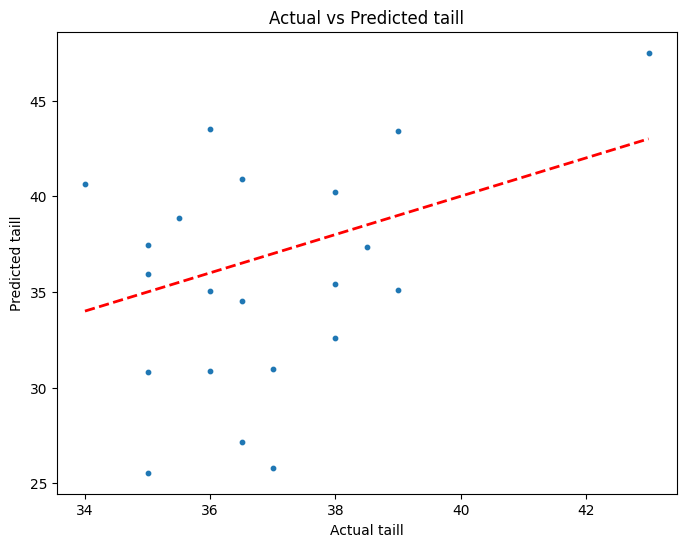


Interpretation:
On average, predictions differ from actual taill by 4.65 units.
The model explains -678.06% of the variance in taill.
     37.00 |      25.79 |      11.21
     36.50 |      34.54 |       1.96
     38.00 |      35.41 |       2.59
     43.00 |      47.50 |      -4.50
     35.00 |      25.56 |       9.44
     35.50 |      38.86 |      -3.36
     37.00 |      30.98 |       6.02
     34.00 |      40.64 |      -6.64
     39.00 |      43.38 |      -4.38
     36.00 |      43.50 |      -7.50


In [45]:
# 예측 성능을 숫자로 확인했으면 이제 시각적으로 확인
# R Score
# 빨간색과 거리가 먼 애들은 예측이 제대로 되지 못함
# Scatter plot 으로 성능을 확인할 수 있음

# Create scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_tensor.cpu(), y_pred, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', linewidth=2)

plt.xlabel(f'Actual {TARGET_COL}')
plt.ylabel(f'Predicted {TARGET_COL}')
plt.title(f'Actual vs Predicted {TARGET_COL}')
plt.show()

print(f"\nInterpretation:")
print(f"On average, predictions differ from actual {TARGET_COL} by {mae:.2f} units.")
print(f"The model explains {r2 * 100:.2f}% of the variance in {TARGET_COL}.")
for i in range(min(10, len(y_true))):
    actual = y_true[i][0]
    predicted_val = y_pred[i][0]
    diff = actual - predicted_val
    print(f"{actual:>10.2f} | {predicted_val:>10.2f} | {diff:>10.2f}")

## 11. Save the Model(Optimal)

추후 사용을 위해 학습된 모델을 저장합니다.

Save the trained model for future use.

In [46]:
# 모델 저장하는 과정
# 이 모델의 가중치를 사용하겠다!
# 지금은 캘리포니아 -> 서울의 집값 예측하고 싶을 때
# 사전학습된 모델에 서울 집값 반영되도록 업데이트, 미세 조정할 수 있음
# 완전 초기화 하지 않고 이 모델의 가중치로 초기화하면 됨

# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


## Summary
### 학습한 내용:
1. **데이터 준비(Data Preparation):** 데이터 로드, 분할, 정규화
2. **PyTorch 텐서(PyTorch Tensors):** 데이터를 PyTorch 형식으로 변환
3. **DataLoader:** 효율적인 학습을 위한 배치 생성
4. **신경망(Neural Network):** 간단한 피드포워드 신경망 구성
5. **학습 루프(Training Loop):** Forward/Backward 패스 구현
6. **평가(Evaluation):** 다양한 지표로 모델 성능 평가
7. **시각화(Visualization):** 학습 과정 및 예측 결과를 그래프로 표현

### 주요 개념:
- **Forward Pass:** 입력 → 은닉층 → 출력
- **Loss Function:** 예측 오차 측정 (MSE)
- **Backward Pass:** 역전파를 통해 기울기 계산
- **Optimizer:** 손실을 최소화하기 위해 가중치 업데이트 (Adam)
- **Epochs:** 학습 데이터 전체를 한 번 모두 학습하는 과정

### 다음으로 해볼 일:
- 다양한 신경망 아키텍처 (레이어 수 조정)
- 다른 활성화 함수
- 다른 옵티마이저 (SGD, RMSprop 등)
- 학습률 스케줄링
- Dropout을 이용한 규제(regularization)

### What We Learned:
1. **Data Preparation:** Loaded, split, and normalized data
2. **PyTorch Tensors:** Converted data to PyTorch format
3. **DataLoader:** Created batches for efficient training
4. **Neural Network:** Built a simple feedforward network
5. **Training Loop:** Implemented forward/backward passes
6. **Evaluation:** Assessed model performance with metrics
7. **Visualization:** Plotted training progress and predictions

### Key Concepts:
- **Forward Pass:** Input → Hidden Layers → Output
- **Loss Function:** Measures prediction error (MSE)
- **ackward Pass:** Computes gradients via backpropagation
- **Optimizer:** Updates weights to minimize loss (Adam)
- **Epochs:** Complete passes through training data

### Next Steps:
Try experimenting with:

- Different network architectures (more/fewer layers)
- Different activation functions
- Different optimizers (SGD, RMSprop)
- Learning rate scheduling
- Dropout for regularization